In [8]:
import torch
from IPython.display import Image as IPythonImage
from PIL import Image, ImageDraw, ImageFont
import io
from tasks.copytask import dataloader
from train import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

In [9]:
from tasks.copytask import CopyTaskModelTraining, CopyTaskBaselineTraining, CopyTaskParams
lstm_ntm_model = CopyTaskModelTraining()
ffw_ntm_model = CopyTaskModelTraining(params=CopyTaskParams(controller_type='ffw-ntm'))
baseline_model = CopyTaskBaselineTraining()

In [10]:
lstm_ntm_model.net.load_state_dict(torch.load("copy-lstm-ntm.model"))
ffw_ntm_model.net.load_state_dict(torch.load("copy-ffw-ntm.model"))
baseline_model.net.load_state_dict(torch.load("copy-baseline.model"))

In [5]:
model = lstm_ntm_model

In [47]:
seq_len = 130
_, x, y = next(iter(dataloader(1, 1, 8, seq_len, seq_len)))
result = evaluate(model.net, model.criterion, x, y)
y_out = result['y_out']

In [48]:
def cmap(value):
    pixval = value * 255
    low = 64
    high = 240
    factor = (255 - low - (255-high)) / 255
    return int(low + pixval * factor)

def draw_sequence(y, u=12):
    seq_len = y.size(0)
    seq_width = y.size(2)
    inset = u // 8
    pad = u // 2
    width = seq_len * u + 2 * pad
    height = seq_width * u + 2 * pad
    im = Image.new('L', (width, height))
    draw = ImageDraw.ImageDraw(im)
    draw.rectangle([0, 0, width, height], fill=250)
    for i in range(seq_len):
        for j in range(seq_width):
            val = 1 - y[i, 0, j].data[0]
            draw.rectangle([pad + i*u + inset,
                            pad + j*u + inset,
                            pad + (i+1)*u - inset,
                            pad + (j+1)*u - inset], fill=cmap(val))

    return im

def im_to_png_bytes(im):
    png = io.BytesIO()
    im.save(png, 'PNG')
    return bytes(png.getbuffer())

def im_vconcat(im1, im2, im3, pad=8):
    assert im1.size == im2.size
    w, h = im1.size

    width = w
    height = h * 3 + pad

    im = Image.new('L', (width, height), color=255)
    im.paste(im1, (0, 0))
    im.paste(im2, (0, h+pad))
    im.paste(im3, (0, 2*(h+pad)))
    return im

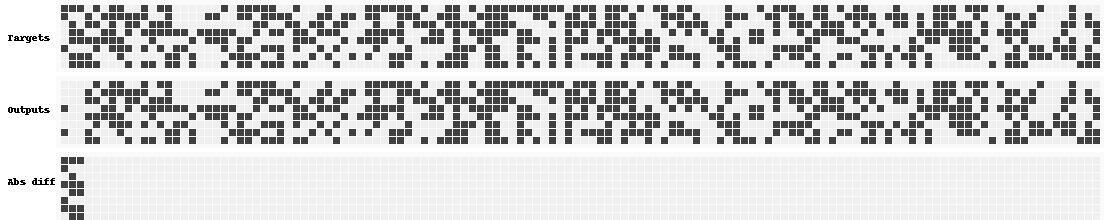

In [49]:
def make_eval_plot(y, y_out, u=12):
    im_y = draw_sequence(y, u)
    im_y_out = draw_sequence(y_out, u)
    diff = draw_sequence((y_out-y).abs(), u)
    im = im_vconcat(im_y, im_y_out, diff, u//2)
    
    w, h = im.size
    pad_w = u * 7
    im2 = Image.new('L', (w+pad_w, h), color=255)
    im2.paste(im, (pad_w, 0))
    
    # Add text
#     font = ImageFont.truetype("./fonts/PT_Sans-Web-Regular.ttf", 13)
    draw = ImageDraw.ImageDraw(im2)
    draw.text((u,4*u), "Targets")#, font=font)
    draw.text((u,13*u), "Outputs")#, font=font)
    draw.text((u,22*u), "Abs diff")#, font=font)
    
    return im2

y_ = y_out.clone()
y_[3:] = y_out[:-3]
y_[:3] = y_out[-3:]
im = make_eval_plot(y, y_, u=8)
IPythonImage(im_to_png_bytes(im))

In [16]:
losses_lstm = []
losses_ffw = []
losses_baseline = []
for seq_len in range(10, 151, 10):
    l = []
    f = []
    b = []
    for _ in range(20):
        _, x, y = next(iter(dataloader(1, 1, 8, seq_len, seq_len)))
        result = evaluate(lstm_ntm_model.net, lstm_ntm_model.criterion, x, y)
        l.append(result['loss'])
        result = evaluate(ffw_ntm_model.net, ffw_ntm_model.criterion, x, y)
        f.append(result['loss'])
        result = evaluate(baseline_model.net, baseline_model.criterion, x, y)
        b.append(result['loss'])
    losses_lstm.append(l)
    losses_ffw.append(f)
    losses_baseline.append(b)
losses_lstm = np.array(losses_lstm)
losses_ffw = np.array(losses_ffw)
losses_baseline = np.array(losses_baseline)

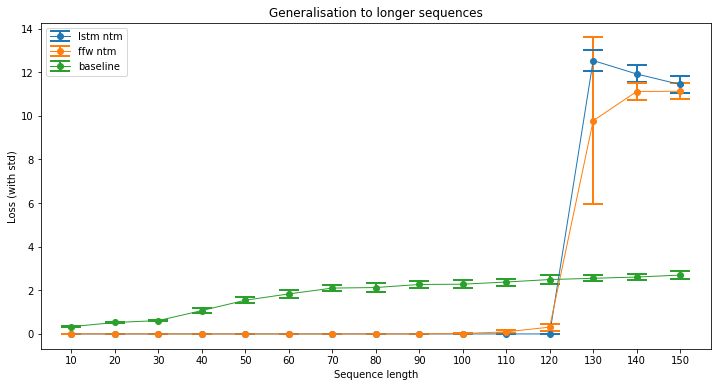

In [18]:
x = range(10, 151, 10)

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.errorbar(x, losses_lstm.mean(axis=1), yerr=losses_lstm.std(axis=1), fmt='o-', elinewidth=2, linewidth=1, label='Cost', capthick=2, capsize=10)
ax.errorbar(x, losses_ffw.mean(axis=1), yerr=losses_ffw.std(axis=1), fmt='o-', elinewidth=2, linewidth=1, label='Cost', capthick=2, capsize=10)
ax.errorbar(x, losses_baseline.mean(axis=1), yerr=losses_baseline.std(axis=1), fmt='o-', elinewidth=2, linewidth=1, label='Cost', capthick=2, capsize=10)
ax.legend(['lstm ntm', 'ffw ntm', 'baseline'])
ax.set_title('Generalisation to longer sequences')
ax.set_xlabel('Sequence length')
ax.set_ylabel('Loss (with std)')
ax.set_xticks(x)
_ = ax.set_xticklabels([str(_x) for _x in x])
fig.savefig('q2c.png', dpi=1000)

In [62]:
ax.set_xticklabels?

Signature: ax.set_xticklabels(labels, fontdict=None, minor=False, **kwargs)
Docstring:
Set the x-tick labels with list of string labels.

..
    ACCEPTS: list of string labels

Parameters
----------
labels : list of str
    List of string labels.

fontdict : dict, optional
    A dictionary controlling the appearance of the ticklabels.
    The default `fontdict` is::

       {'fontsize': rcParams['axes.titlesize'],
        'fontweight': rcParams['axes.titleweight'],
        'verticalalignment': 'baseline',
        'horizontalalignment': loc}

minor : bool, optional
    Whether to set the minor ticklabels rather than the major ones.

Returns
-------
A list of `~.text.Text` instances.

Other Parameters
-----------------
**kwargs : `~.text.Text` properties.
File:      ~/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/axes/_base.py
Type:      method


--------

# Losses

In [11]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [12]:
losses = []
for fn in ['copy-lstm-ntm.json', 'copy-ffw-ntm.json', 'copy-baseline.json']:
    with open(fn) as f:
        data = json.load(f)
    losses.append(moving_average(data['loss'], n=78))
losses = np.array(losses)

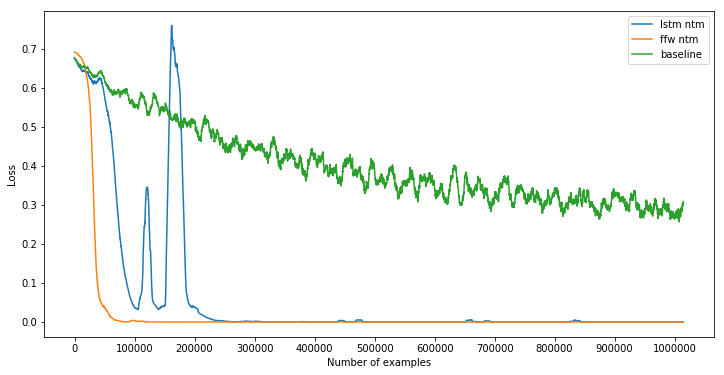

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
x = np.arange(len(losses[0]))
ax.plot(x, losses.T)
ax.set_xticks(range(0,len(losses[0]), 781))
_ = ax.set_xticklabels([str(_x) for _x in range(0,128*8000+1, 100000)])
ax.legend(['lstm ntm', 'ffw ntm', 'baseline'])
ax.set_xlabel('Number of examples')
ax.set_ylabel('Loss')
fig.savefig('q2b.png', dpi=1000)